In [1]:
import pandas as pd
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from data_manager import Wiki_Data_Manager
import nltk
import pandas as pd
import random
from sklearn.manifold  import TSNE

from utils import plot, get_pcs
import deps

/home/wjy/miniconda3/envs/normal/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
deps.set_seed(20001202)
DEVICE_ID = 1
MODEL_HUB_PATH = '/home_sda1/wjy/model_hub'
MODEL_NAME = 'llama3.1-8b'

device = deps.get_device(DEVICE_ID)
model, tok = deps.load_model(MODEL_HUB_PATH, MODEL_NAME, device)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Running task on device cuda:1


Loading checkpoint shards: 100%|██████████| 4/4 [01:26<00:00, 21.63s/it]


In [3]:
deps.count_params(model)

|               |      one      |    billion    |
|training params|  1050939392   |     1.05      |
|  all params   |  4540600320   |     4.54      |


In [4]:
DATASET_NAME = 'NQ'
CACHE_PATH = '/home_sda1/wjy/cache/work2_try2/hidden_status'

statements_template = 'For the prompt "{}", the token "{}" will appear in the generated text for the prompt above.'

whole_data = pd.read_csv(os.path.join('./data/', DATASET_NAME, DATASET_NAME + '_' + MODEL_NAME + '.csv'))

In [5]:
center = True
scale = False

In [6]:
def get_df_and_hs(known_id, layer):
    df = whole_data.groupby('known_id').get_group(known_id).copy()
    hs_file_name = "layer_{}.pt".format(layer)
    hs = torch.load(os.path.join(CACHE_PATH, MODEL_NAME, DATASET_NAME, str(known_id), hs_file_name))
    print(os.path.join(CACHE_PATH, MODEL_NAME, DATASET_NAME, str(known_id), hs_file_name))
    assert len(df) == hs.shape[0], (len(df), hs.shape[0])

    if center:
        acts = hs - torch.mean(hs, dim=0)
    if scale:
        acts = hs / torch.std(hs, dim=0)

    df['activation'] = list(acts)

    return df, hs

def get_raw_df(known_id):
    df = whole_data.groupby('known_id').get_group(known_id).copy()
    return df

In [7]:
def get_proj(df, pcs):
    acts = df['activation'].tolist()
    acts = torch.stack(acts, dim=0).cuda()
    proj = torch.mm(acts, pcs)
    return proj.cpu()

def get_pcs_dim2(df):
    acts = df['activation'].tolist()
    acts = torch.stack(acts, dim=0).cuda()
    pcs = get_pcs(acts, k=2, offset=0)
    return pcs

def split_pos_and_neg(proj):
    pos_sample = np.array([proj.numpy()[i, :] for i in range(len(proj)) if i % 2 == 0])
    neg_sample = np.array([proj.numpy()[i, :] for i in range(len(proj)) if i % 2 != 0])
    return pos_sample, neg_sample

# NQ

In [9]:
layers = [14]
seed = 0
MODEL_NAME = 'llama3.1-8b'
known_id_list = os.listdir(os.path.join(CACHE_PATH, MODEL_NAME, DATASET_NAME))

In [27]:
df_list = []
for known_id in known_id_list:
    df_list.append(get_raw_df(int(known_id)))
df = pd.concat(df_list)

In [30]:
stataments = list(df['statement'])

acts = []
for sts_idx in tqdm(range(0, len(stataments), 1)):
    cur_acts = deps.collect_hiiden_states_no_nnsight(stataments[sts_idx: sts_idx + 1], model, tok, layers=layers, target_token_idx=-1)
    # cur_acts = deps.collect_features_no_nnsight(stataments[sts_idx: sts_idx + 1], model, tok, 'model.layers.{}.self_attn', layers=layers, target_token_idx=-1)
    acts.append(cur_acts[layers[0]].detach().cpu())

acts = torch.cat(acts, dim=0).float()
if center:
    acts = acts - torch.mean(acts, dim=0)
if scale:
    acts = acts / torch.std(acts, dim=0)

df['activation'] = list(acts.detach())

  0%|          | 0/1000 [00:00<?, ?it/s]We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
/home/wjy/miniconda3/envs/normal/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:435: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
100%|██████████| 1000/1000 [02:54<00:00,  5.73it/s]


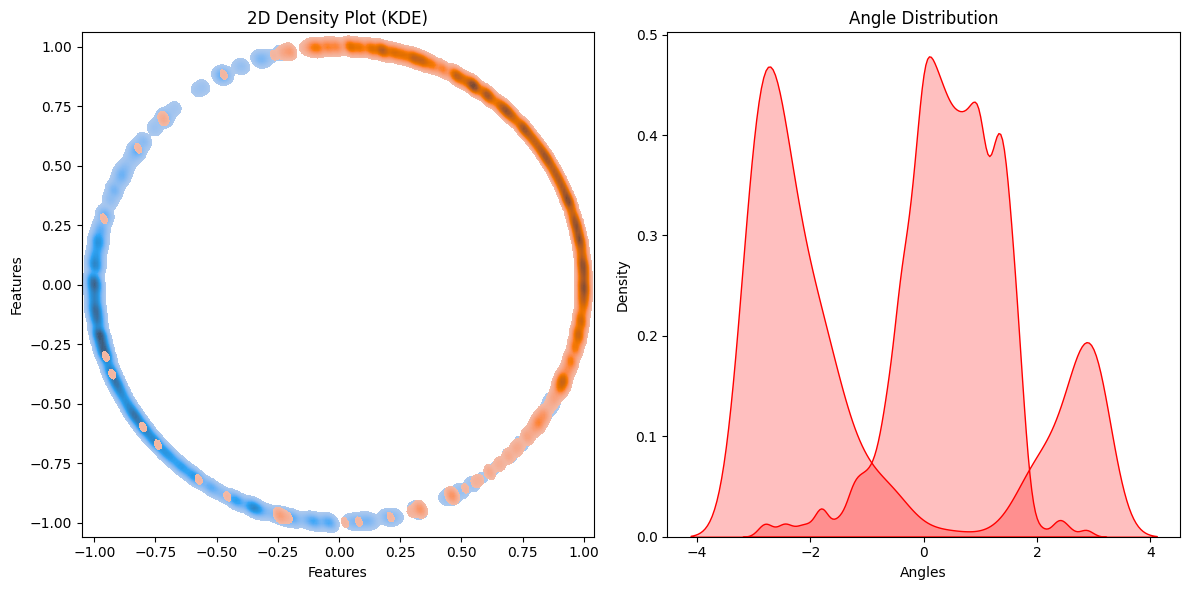

In [39]:
# tsne-kde
import seaborn as sns
acts = df['activation'].tolist()
acts = torch.stack(acts, dim=0).cuda()
acts = acts.detach().cpu().numpy()
# Step 1: 使用 t-SNE 将高维表示降维到 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
user_2d = tsne.fit_transform(acts)

user_2d_normalized = user_2d / np.linalg.norm(user_2d, axis=1, keepdims=True)

pos_sample, neg_sample = split_pos_and_neg(torch.tensor(user_2d_normalized))


# Step 3: 绘制密度分布图（KDE）
plt.figure(figsize=(12, 6))

# KDE 可视化
plt.subplot(1, 2, 1)
sns.kdeplot(
    x=pos_sample[:, 0],
    y=pos_sample[:, 1],
    fill=True,
    # cmap="Reds",
    bw_adjust=0.1,
    levels=100,
    label='pos'
)
sns.kdeplot(
    x=neg_sample[:, 0],
    y=neg_sample[:, 1],
    fill=True,
    # cmap="Reds",
    bw_adjust=0.1,
    levels=100,
    label='neg'
)
plt.title("2D Density Plot (KDE)")
plt.xlabel("Features")
plt.ylabel("Features")

# Step 4: 计算用户表示的角度分布
angles = np.arctan2(user_2d_normalized[:, 1], user_2d_normalized[:, 0])
angles_pos = np.arctan2(pos_sample[:, 1], pos_sample[:, 0])
angles_neg = np.arctan2(neg_sample[:, 1], neg_sample[:, 0])

# 绘制角度分布密度图
plt.subplot(1, 2, 2)
sns.kdeplot(
    angles_pos,
    fill=True,
    color="red",
    bw_adjust=0.5
)
sns.kdeplot(
    angles_neg,
    fill=True,
    color="red",
    bw_adjust=0.5
)
plt.title("Angle Distribution")
plt.xlabel("Angles")
plt.ylabel("Density")

# 展示图像
plt.tight_layout()
plt.show()


In [33]:
pcs = get_pcs_dim2(df)

proj = get_proj(df, pcs)

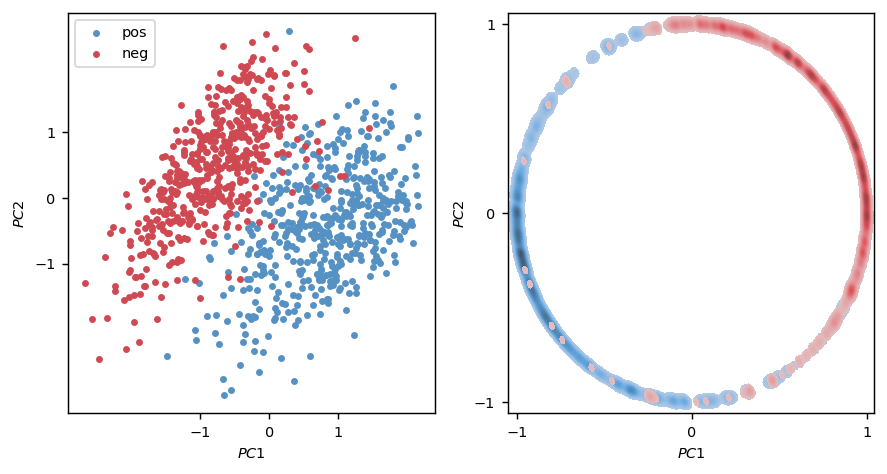

In [41]:
fig = plt.figure(figsize=(8, 4), dpi=130)

fontsize=8
pointsize=8

pos_color = '#5591C2'
neg_color = '#CF4952'

plt.subplot(1, 2, 2)

# pos_sample, neg_sample = split_pos_and_neg(proj)
# plt.scatter(pos_sample[:, 0], pos_sample[:, 1], s=pointsize, label='pos', c=pos_color)
# plt.scatter(neg_sample[:, 0], neg_sample[:, 1], s=pointsize, label='neg', c=neg_color)
sns.kdeplot(
    x=pos_sample[:, 0],
    y=pos_sample[:, 1],
    fill=True,
    # cmap="Reds",
    bw_adjust=0.1,
    levels=100,
    label='pos',
    color=pos_color,
)
sns.kdeplot(
    x=neg_sample[:, 0],
    y=neg_sample[:, 1],
    fill=True,
    # cmap="Reds",
    bw_adjust=0.1,
    levels=100,
    label='neg',
    color=neg_color
)
plt.xlabel('${PC1}$', fontsize=fontsize)
plt.ylabel('${PC2}$', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])
# plt.legend(fontsize=fontsize)

plt.subplot(1, 2, 1)

ours_pos_sample, ours_neg_sample = split_pos_and_neg(proj)
plt.scatter(ours_pos_sample[:, 0], ours_pos_sample[:, 1], s=pointsize, label='pos', c=pos_color)
plt.scatter(ours_neg_sample[:, 0], ours_neg_sample[:, 1], s=pointsize, label='neg', c=neg_color)
plt.xlabel('${PC1}$', fontsize=fontsize)
plt.ylabel('${PC2}$', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])

plt.legend(fontsize=fontsize)
# plt.show()
plt.savefig('./figs/pre.pdf', bbox_inches='tight')

In [43]:
NQ_data = [pos_sample, neg_sample, ours_pos_sample, ours_neg_sample]

# NQ

In [45]:
DATASET_NAME = 'WebQ'
CACHE_PATH = '/home_sda1/wjy/cache/work2_try2/hidden_status'

statements_template = 'For the prompt "{}", the token "{}" will appear in the generated text for the prompt above.'

whole_data = pd.read_csv(os.path.join('./data/', DATASET_NAME, DATASET_NAME + '_' + MODEL_NAME + '.csv'))



layers = [14]
seed = 0
MODEL_NAME = 'llama3.1-8b'
known_id_list = os.listdir(os.path.join(CACHE_PATH, MODEL_NAME, DATASET_NAME))

df_list = []
for known_id in known_id_list:
    df_list.append(get_raw_df(int(known_id)))
df = pd.concat(df_list)

stataments = list(df['statement'])

acts = []
for sts_idx in tqdm(range(0, len(stataments), 1)):
    cur_acts = deps.collect_hiiden_states_no_nnsight(stataments[sts_idx: sts_idx + 1], model, tok, layers=layers, target_token_idx=-1)
    # cur_acts = deps.collect_features_no_nnsight(stataments[sts_idx: sts_idx + 1], model, tok, 'model.layers.{}.self_attn', layers=layers, target_token_idx=-1)
    acts.append(cur_acts[layers[0]].detach().cpu())

acts = torch.cat(acts, dim=0).float()
if center:
    acts = acts - torch.mean(acts, dim=0)
if scale:
    acts = acts / torch.std(acts, dim=0)

df['activation'] = list(acts.detach())

100%|██████████| 1000/1000 [02:50<00:00,  5.86it/s]


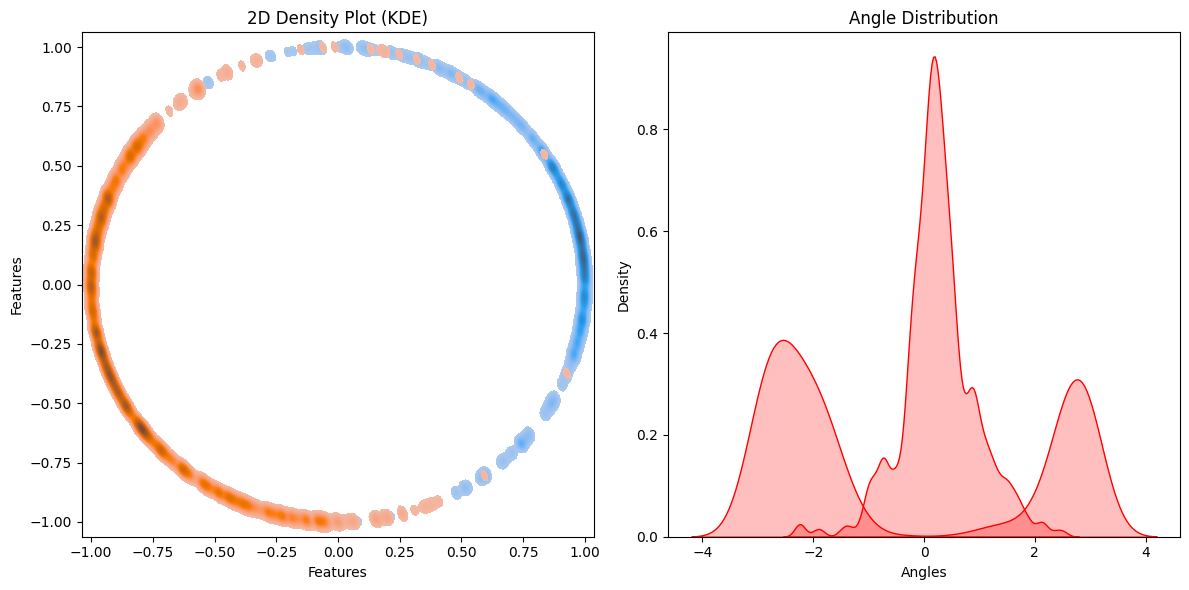

In [46]:
# tsne-kde
import seaborn as sns
acts = df['activation'].tolist()
acts = torch.stack(acts, dim=0).cuda()
acts = acts.detach().cpu().numpy()
# Step 1: 使用 t-SNE 将高维表示降维到 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
user_2d = tsne.fit_transform(acts)

user_2d_normalized = user_2d / np.linalg.norm(user_2d, axis=1, keepdims=True)

pos_sample, neg_sample = split_pos_and_neg(torch.tensor(user_2d_normalized))


# Step 3: 绘制密度分布图（KDE）
plt.figure(figsize=(12, 6))

# KDE 可视化
plt.subplot(1, 2, 1)
sns.kdeplot(
    x=pos_sample[:, 0],
    y=pos_sample[:, 1],
    fill=True,
    # cmap="Reds",
    bw_adjust=0.1,
    levels=100,
    label='pos'
)
sns.kdeplot(
    x=neg_sample[:, 0],
    y=neg_sample[:, 1],
    fill=True,
    # cmap="Reds",
    bw_adjust=0.1,
    levels=100,
    label='neg'
)
plt.title("2D Density Plot (KDE)")
plt.xlabel("Features")
plt.ylabel("Features")

# Step 4: 计算用户表示的角度分布
angles = np.arctan2(user_2d_normalized[:, 1], user_2d_normalized[:, 0])
angles_pos = np.arctan2(pos_sample[:, 1], pos_sample[:, 0])
angles_neg = np.arctan2(neg_sample[:, 1], neg_sample[:, 0])

# 绘制角度分布密度图
plt.subplot(1, 2, 2)
sns.kdeplot(
    angles_pos,
    fill=True,
    color="red",
    bw_adjust=0.5
)
sns.kdeplot(
    angles_neg,
    fill=True,
    color="red",
    bw_adjust=0.5
)
plt.title("Angle Distribution")
plt.xlabel("Angles")
plt.ylabel("Density")

# 展示图像
plt.tight_layout()
plt.show()


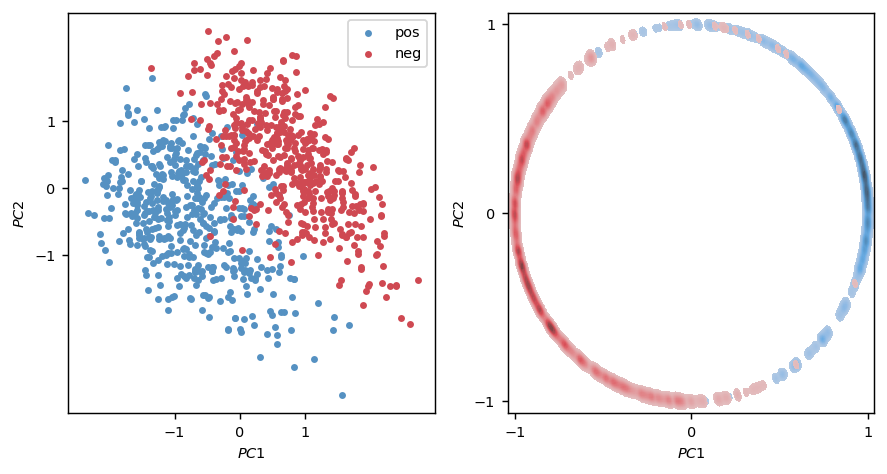

In [47]:
pcs = get_pcs_dim2(df)

proj = get_proj(df, pcs)

fig = plt.figure(figsize=(8, 4), dpi=130)

fontsize=8
pointsize=8

pos_color = '#5591C2'
neg_color = '#CF4952'

plt.subplot(1, 2, 2)

# pos_sample, neg_sample = split_pos_and_neg(proj)
# plt.scatter(pos_sample[:, 0], pos_sample[:, 1], s=pointsize, label='pos', c=pos_color)
# plt.scatter(neg_sample[:, 0], neg_sample[:, 1], s=pointsize, label='neg', c=neg_color)
sns.kdeplot(
    x=pos_sample[:, 0],
    y=pos_sample[:, 1],
    fill=True,
    # cmap="Reds",
    bw_adjust=0.1,
    levels=100,
    label='pos',
    color=pos_color,
)
sns.kdeplot(
    x=neg_sample[:, 0],
    y=neg_sample[:, 1],
    fill=True,
    # cmap="Reds",
    bw_adjust=0.1,
    levels=100,
    label='neg',
    color=neg_color
)
plt.xlabel('${PC1}$', fontsize=fontsize)
plt.ylabel('${PC2}$', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])
# plt.legend(fontsize=fontsize)

plt.subplot(1, 2, 1)

ours_pos_sample, ours_neg_sample = split_pos_and_neg(proj)
plt.scatter(ours_pos_sample[:, 0], ours_pos_sample[:, 1], s=pointsize, label='pos', c=pos_color)
plt.scatter(ours_neg_sample[:, 0], ours_neg_sample[:, 1], s=pointsize, label='neg', c=neg_color)
plt.xlabel('${PC1}$', fontsize=fontsize)
plt.ylabel('${PC2}$', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])

plt.legend(fontsize=fontsize)
# plt.show()
plt.savefig('./figs/pre.pdf', bbox_inches='tight')

In [48]:
WebQ_data = [pos_sample, neg_sample, ours_pos_sample, ours_neg_sample]

# Amazon

In [52]:
DATASET_NAME = 'Amazon'
CACHE_PATH = '/home_sda1/wjy/cache/work2_try2/hidden_status'

statements_template = 'For the prompt "{}", the token "{}" will appear in the generated text for the prompt above.'

whole_data = pd.read_csv(os.path.join('./data/', DATASET_NAME, DATASET_NAME + '_' + MODEL_NAME + '.csv'))



layers = [14]
seed = 0
MODEL_NAME = 'llama3.1-8b'
known_id_list = os.listdir(os.path.join(CACHE_PATH, MODEL_NAME, DATASET_NAME))

df_list = []
for known_id in known_id_list:
    df_list.append(get_raw_df(int(known_id)))
df = pd.concat(df_list)

stataments = list(df['statement'])

acts = []
for sts_idx in tqdm(range(0, len(stataments), 1)):
    cur_acts = deps.collect_hiiden_states_no_nnsight(stataments[sts_idx: sts_idx + 1], model, tok, layers=layers, target_token_idx=-1)
    # cur_acts = deps.collect_features_no_nnsight(stataments[sts_idx: sts_idx + 1], model, tok, 'model.layers.{}.self_attn', layers=layers, target_token_idx=-1)
    acts.append(cur_acts[layers[0]].detach().cpu())

acts = torch.cat(acts, dim=0).float()
if center:
    acts = acts - torch.mean(acts, dim=0)
if scale:
    acts = acts / torch.std(acts, dim=0)

df['activation'] = list(acts.detach())

100%|██████████| 1000/1000 [03:07<00:00,  5.34it/s]


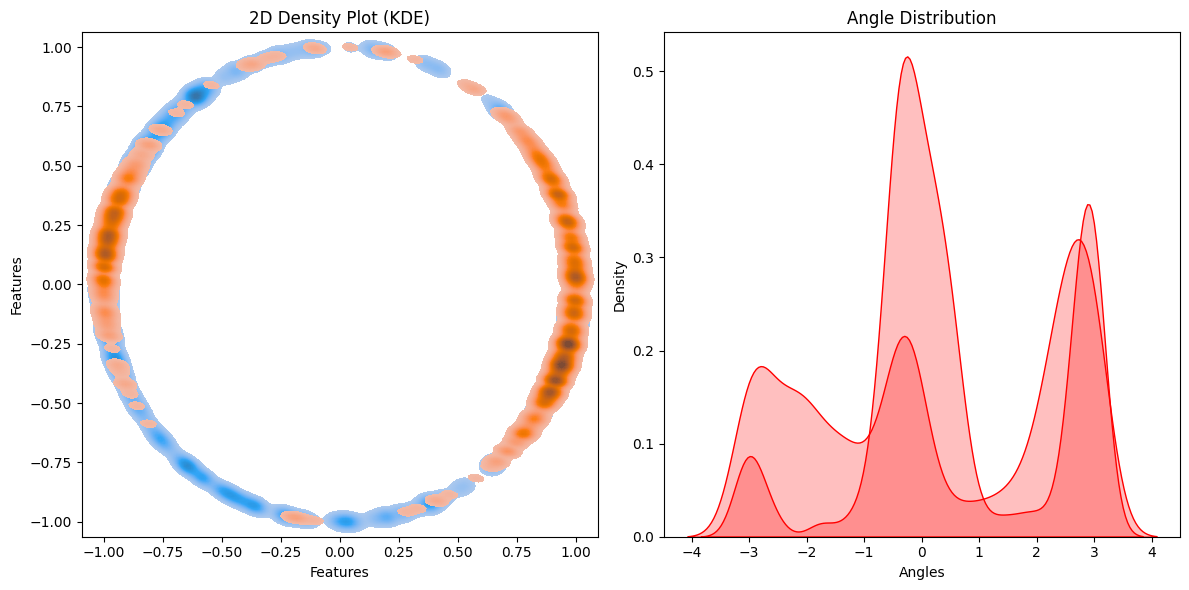

In [53]:
# tsne-kde
import seaborn as sns
acts = df['activation'].tolist()
acts = torch.stack(acts, dim=0).cuda()
acts = acts.detach().cpu().numpy()
# Step 1: 使用 t-SNE 将高维表示降维到 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
user_2d = tsne.fit_transform(acts)

user_2d_normalized = user_2d / np.linalg.norm(user_2d, axis=1, keepdims=True)

pos_sample, neg_sample = split_pos_and_neg(torch.tensor(user_2d_normalized))


# Step 3: 绘制密度分布图（KDE）
plt.figure(figsize=(12, 6))

# KDE 可视化
plt.subplot(1, 2, 1)
sns.kdeplot(
    x=pos_sample[:, 0],
    y=pos_sample[:, 1],
    fill=True,
    # cmap="Reds",
    bw_adjust=0.1,
    levels=100,
    label='pos'
)
sns.kdeplot(
    x=neg_sample[:, 0],
    y=neg_sample[:, 1],
    fill=True,
    # cmap="Reds",
    bw_adjust=0.1,
    levels=100,
    label='neg'
)
plt.title("2D Density Plot (KDE)")
plt.xlabel("Features")
plt.ylabel("Features")

# Step 4: 计算用户表示的角度分布
angles = np.arctan2(user_2d_normalized[:, 1], user_2d_normalized[:, 0])
angles_pos = np.arctan2(pos_sample[:, 1], pos_sample[:, 0])
angles_neg = np.arctan2(neg_sample[:, 1], neg_sample[:, 0])

# 绘制角度分布密度图
plt.subplot(1, 2, 2)
sns.kdeplot(
    angles_pos,
    fill=True,
    color="red",
    bw_adjust=0.5
)
sns.kdeplot(
    angles_neg,
    fill=True,
    color="red",
    bw_adjust=0.5
)
plt.title("Angle Distribution")
plt.xlabel("Angles")
plt.ylabel("Density")

# 展示图像
plt.tight_layout()
plt.show()


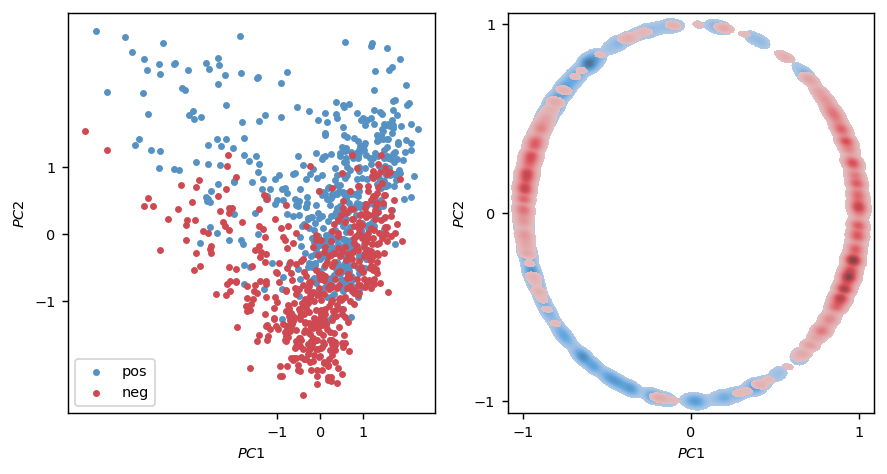

In [54]:
pcs = get_pcs_dim2(df)

proj = get_proj(df, pcs)

fig = plt.figure(figsize=(8, 4), dpi=130)

fontsize=8
pointsize=8

pos_color = '#5591C2'
neg_color = '#CF4952'

plt.subplot(1, 2, 2)

# pos_sample, neg_sample = split_pos_and_neg(proj)
# plt.scatter(pos_sample[:, 0], pos_sample[:, 1], s=pointsize, label='pos', c=pos_color)
# plt.scatter(neg_sample[:, 0], neg_sample[:, 1], s=pointsize, label='neg', c=neg_color)
sns.kdeplot(
    x=pos_sample[:, 0],
    y=pos_sample[:, 1],
    fill=True,
    # cmap="Reds",
    bw_adjust=0.1,
    levels=100,
    label='pos',
    color=pos_color,
)
sns.kdeplot(
    x=neg_sample[:, 0],
    y=neg_sample[:, 1],
    fill=True,
    # cmap="Reds",
    bw_adjust=0.1,
    levels=100,
    label='neg',
    color=neg_color
)
plt.xlabel('${PC1}$', fontsize=fontsize)
plt.ylabel('${PC2}$', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])
# plt.legend(fontsize=fontsize)

plt.subplot(1, 2, 1)

ours_pos_sample, ours_neg_sample = split_pos_and_neg(proj)
plt.scatter(ours_pos_sample[:, 0], ours_pos_sample[:, 1], s=pointsize, label='pos', c=pos_color)
plt.scatter(ours_neg_sample[:, 0], ours_neg_sample[:, 1], s=pointsize, label='neg', c=neg_color)
plt.xlabel('${PC1}$', fontsize=fontsize)
plt.ylabel('${PC2}$', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])

plt.legend(fontsize=fontsize)
# plt.show()
plt.savefig('./figs/pre.pdf', bbox_inches='tight')

In [55]:
Amazon_data = [pos_sample, neg_sample, ours_pos_sample, ours_neg_sample]

# Plot

In [66]:
plt.rcParams['font.family'] = 'Times New Roman'

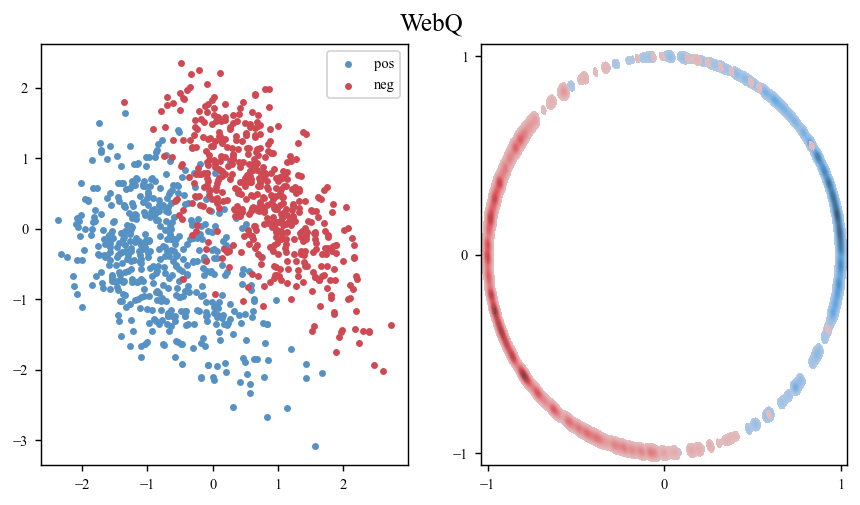

In [79]:
pos_sample, neg_sample, ours_pos_sample, ours_neg_sample = WebQ_data
title_name = 'WebQ'

fig = plt.figure(figsize=(8, 4), dpi=130)


fontsize=8
pointsize=8
pos_color = '#5591C2'
neg_color = '#CF4952'

plt.subplot(1, 2, 2)

sns.kdeplot(x=pos_sample[:, 0], y=pos_sample[:, 1], fill=True, bw_adjust=0.1, levels=100, label='pos', color=pos_color)
sns.kdeplot(x=neg_sample[:, 0], y=neg_sample[:, 1], fill=True, bw_adjust=0.1, levels=100, label='neg', color=neg_color)
# plt.xlabel('${PC1}$', fontsize=fontsize)
# plt.ylabel('${PC2}$', fontsize=fontsize)
plt.xticks([-1, 0, 1], fontsize=fontsize)
plt.yticks([-1, 0, 1], fontsize=fontsize)



plt.subplot(1, 2, 1)
plt.scatter(ours_pos_sample[:, 0], ours_pos_sample[:, 1], s=pointsize, label='pos', c=pos_color)
plt.scatter(ours_neg_sample[:, 0], ours_neg_sample[:, 1], s=pointsize, label='neg', c=neg_color)
# plt.xlabel('${PC1}$', fontsize=fontsize)
# plt.ylabel('${PC2}$', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.legend(fontsize=fontsize)

plt.suptitle(title_name, fontsize=fontsize + 6)
fig.subplots_adjust(top=0.92)  # 0.92 表示离顶部稍微近一点，数字越小，标题越上
# plt.show()
plt.savefig('./figs/dataset_WebQ.pdf', bbox_inches='tight')

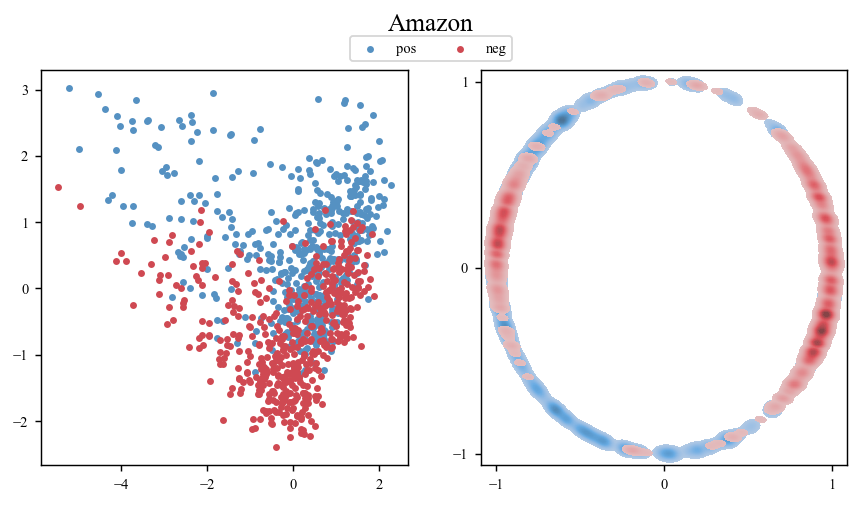

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 Amazon_data 是已经定义好的数据
pos_sample, neg_sample, ours_pos_sample, ours_neg_sample = Amazon_data
title_name = 'Amazon'

fig = plt.figure(figsize=(8, 4), dpi=130)

fontsize = 8
pointsize = 8
pos_color = '#5591C2'
neg_color = '#CF4952'

# 子图1
plt.subplot(1, 2, 2)

sns.kdeplot(x=pos_sample[:, 0], y=pos_sample[:, 1], fill=True, bw_adjust=0.1, levels=100, label='pos', color=pos_color)
sns.kdeplot(x=neg_sample[:, 0], y=neg_sample[:, 1], fill=True, bw_adjust=0.1, levels=100, label='neg', color=neg_color)
plt.xticks([-1, 0, 1], fontsize=fontsize)
plt.yticks([-1, 0, 1], fontsize=fontsize)

# 子图2
plt.subplot(1, 2, 1)
plt.scatter(ours_pos_sample[:, 0], ours_pos_sample[:, 1], s=pointsize, label='pos', c=pos_color)
plt.scatter(ours_neg_sample[:, 0], ours_neg_sample[:, 1], s=pointsize, label='neg', c=neg_color)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

# 添加大图标题
plt.suptitle(title_name, fontsize=fontsize + 6)

# 调整子图与大图标题之间的距离
fig.subplots_adjust(top=0.87)  # 0.92 表示离顶部稍微近一点，数字越小，标题越上

# 在大图上添加图例
handles, labels = plt.gca().get_legend_handles_labels()  # 获取所有图形的图例句柄
fig.legend(handles, labels, loc='upper center', ncol=6, fontsize=fontsize, bbox_to_anchor=(0.5, 0.95))

# 显示图形
plt.show()

# 保存图形（如果需要）
# plt.savefig('./figs/pre.pdf', bbox_inches='tight')
